Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Custom Methods

## Model Metrics Visualization

In [ ]:
def model_metrics_visualization(history_variable, epochs):
  acc = history_variable.history['accuracy']
  val_acc = history_variable.history['val_accuracy']

  loss = history_variable.history['loss']
  val_loss = history_variable.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

# Importing Skin Cancer Data


In [ ]:
# Downloading Database using GDrive link

import gdown

# Replace 'file_id_here' with the actual file ID
#file_id = 'https://drive.google.com/u/0/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&export=download'

# Replace 'output_file_name' with the desired name for the downloaded file
output_file = 'skin_database'

# Construct the download link
gdrive_url = 'https://drive.google.com/u/0/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&export=download'

# Download the file
gdown.download(gdrive_url, output_file, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&export=download
To: /content/skin_database
100%|██████████| 824M/824M [00:09<00:00, 90.4MB/s]


'skin_database'

In [ ]:
# Unzipping the database
!unzip /content/skin_database -d /content/skin_db

In [ ]:
# Removing the zip file
os.remove('/content/skin_database')

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


We have total 2357 images

# Creating Training & Test dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data


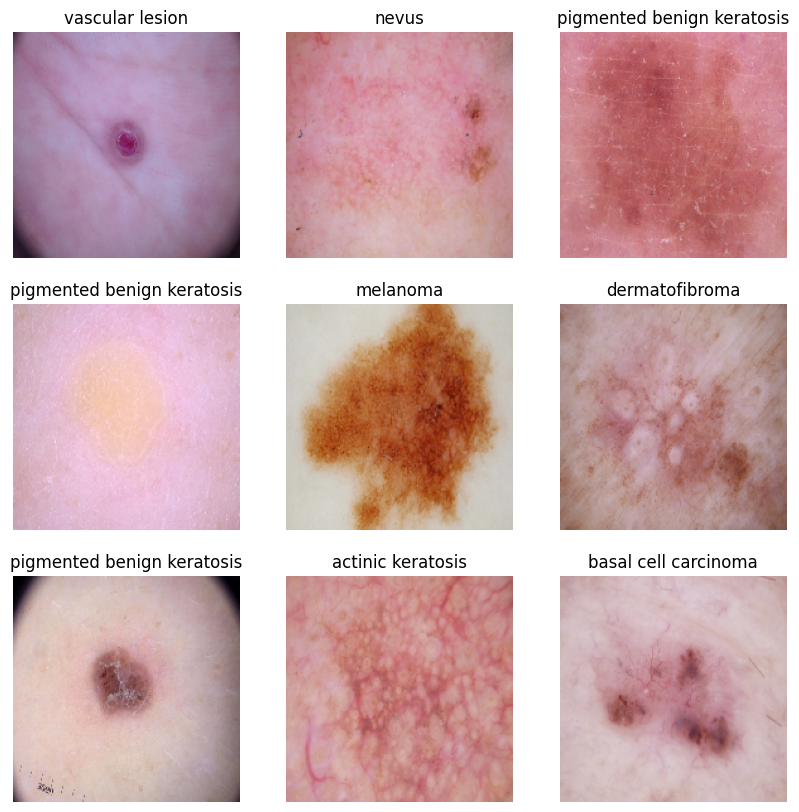

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [ ]:
# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model 1:

Base Line Model

## Model Creation

In [ ]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

## Model Compilation

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Model Training

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 26s 69ms/step - loss: 1.9115 - accuracy: 0.2796 - val_loss: 1.7762 - val_accuracy: 0.3669
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.6803 - accuracy: 0.3956 - val_loss: 1.6192 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6265 - accuracy: 0.4302 - val_loss: 1.5645 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4569 - accuracy: 0.4844 - val_loss: 1.4791 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3640 - accuracy: 0.5167 - val_loss: 1.4022 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3083 - accuracy: 0.5312 - val_loss: 1.3543 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2632 - accuracy: 0.5480 - val_loss: 1.4046 - val_accuracy: 0.4832
Epoch 8/20
5

## Visualizing results

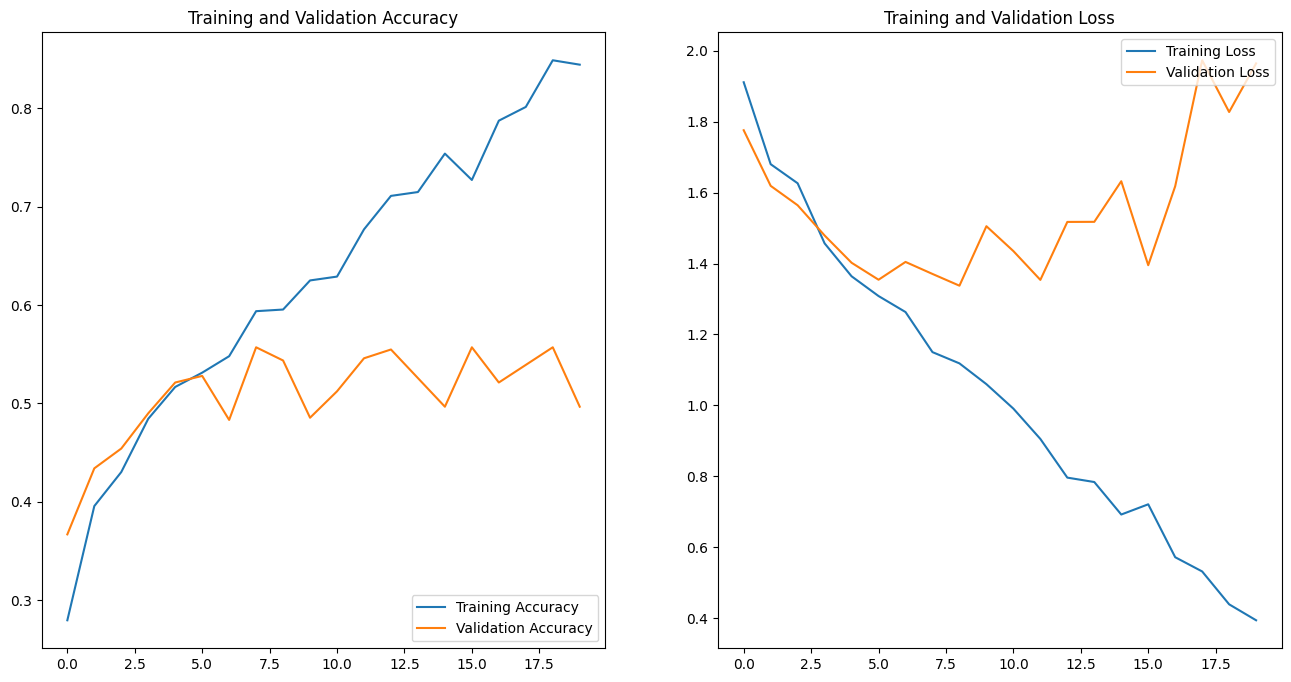

In [ ]:
model_metrics_visualization(history, epochs)

## Findings:
1. From the accuracy graph, we can notice that the model is highly overfit as there is huge gap b/w training & validation accuracy.
2. Similarly, we can notice that there is huge gap b/w training (less error) & validation loss (more error) which indicates overfitting.

To overcome overfitting, we can do data augmentation to increase our training data size so that our model 'll be able to learn some generalized patterns.

# Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

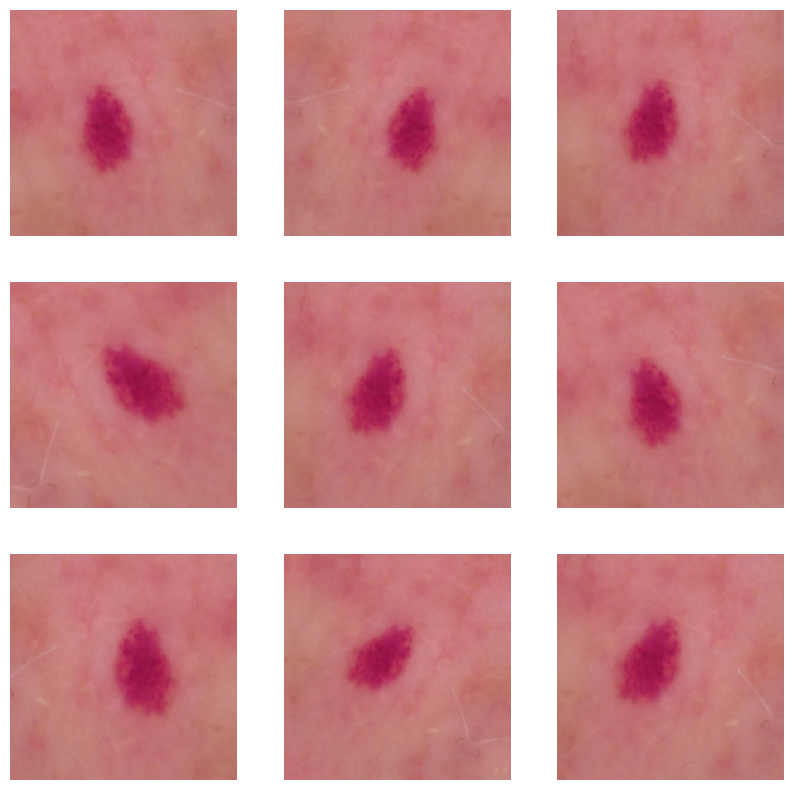

In [ ]:
# Visualizing Augmented Dataset

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model 2:

With dropput layer & Augmented Data (with class imbalance)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 35ms/step - loss: 1.9685 - accuracy: 0.2701 - val_loss: 1.7874 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.6955 - accuracy: 0.3923 - val_loss: 1.6307 - val_accuracy: 0.4049
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5749 - accuracy: 0.4291 - val_loss: 1.6510 - val_accuracy: 0.4183
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5023 - accuracy: 0.4732 - val_loss: 1.4666 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 2s 33ms/step - loss: 1.4650 - accuracy: 0.4849 - val_loss: 1.5275 - val_accuracy: 0.4385
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4531 - accuracy: 0.4905 - val_loss: 1.4908 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3812 - accuracy: 0.5123 - val_loss: 1.4054 - val_accuracy: 0.5123
Epoch 8/20
56

### Visualizing the results

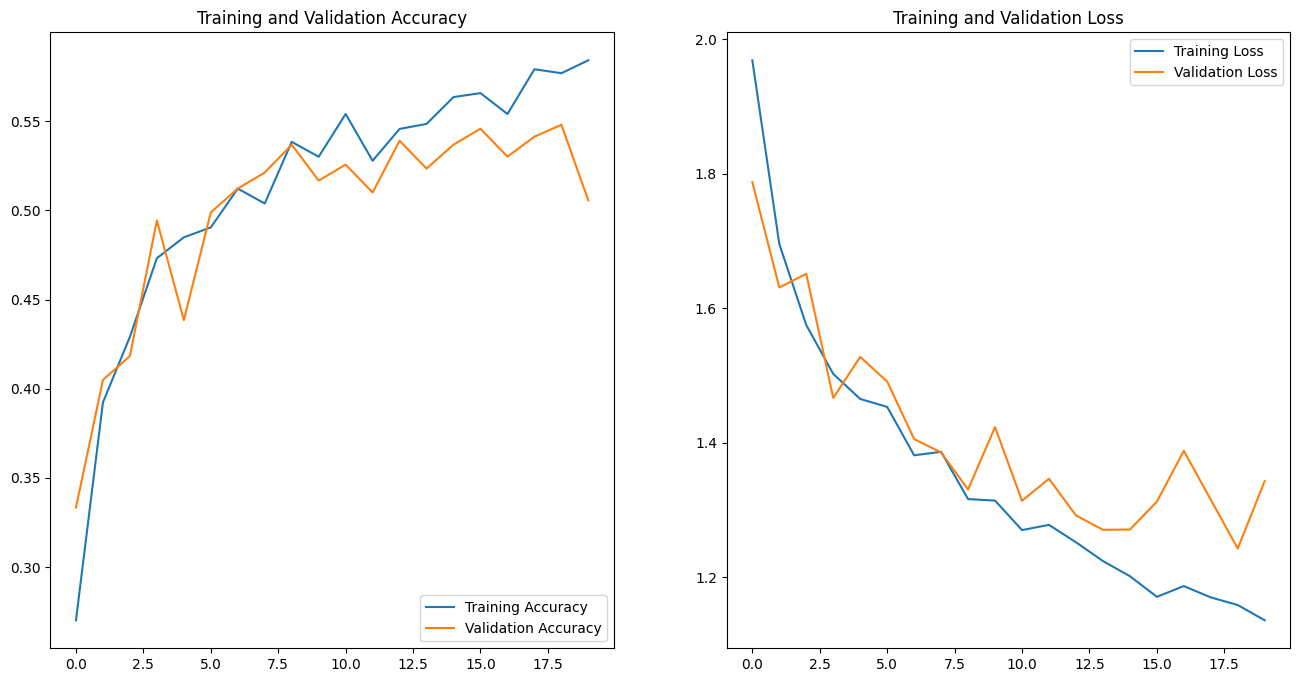

In [ ]:
model_metrics_visualization(history, epochs)

## Findings:
1. We can notice that the gap b/w training & validation accuracy is acceptable which indicates that model doesn't overfit.
2. Similarly, we can find the same pattern in the loss value.

But the overall accuracy is low, therefore, we need to further improve our model via data modification.

As a 1st step we can check for data imbalance as it have a detrimental effect on the model performance.

# Checking Class Imbalance

In [ ]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/skin_db/Skin cancer ISIC The Internat...,pigmented benign keratosis
1,/content/skin_db/Skin cancer ISIC The Internat...,pigmented benign keratosis
2,/content/skin_db/Skin cancer ISIC The Internat...,pigmented benign keratosis
3,/content/skin_db/Skin cancer ISIC The Internat...,pigmented benign keratosis
4,/content/skin_db/Skin cancer ISIC The Internat...,pigmented benign keratosis
...,...,...
2234,/content/skin_db/Skin cancer ISIC The Internat...,actinic keratosis
2235,/content/skin_db/Skin cancer ISIC The Internat...,actinic keratosis
2236,/content/skin_db/Skin cancer ISIC The Internat...,actinic keratosis
2237,/content/skin_db/Skin cancer ISIC The Internat...,actinic keratosis


Class=5, n=462 (20.634%)
Class=8, n=139 (6.208%)
Class=4, n=357 (15.945%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=0, n=114 (5.092%)


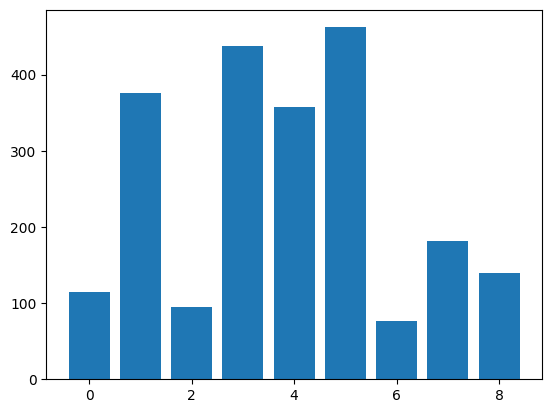

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

## Findings:
1. Class '6' has the least no. of samples.
2. Class '5' has the most no. of samples.

We can clearly notice the high class imbalance. Therefore, we need to handle that.

One way to handle that is by using '[Augmentor](https://augmentor.readthedocs.io/en/master/)' which adds some images to all the classes therefore none of the class 'll have very few samples.

## Handling Class Imbalance

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5F0FFBC250>: 100%|██████████| 500/500 [00:19<00:00, 25.85 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5E87BEBCD0>: 100%|██████████| 500/500 [00:15<00:00, 31.35 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5E87C8AF50>: 100%|██████████| 500/500 [00:14<00:00, 34.84 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7C5E87C57B20>: 100%|██████████| 500/500 [01:13<00:00,  6.80 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7C5E87942FB0>: 100%|██████████| 500/500 [01:13<00:00,  6.84 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5E87987C10>: 100%|██████████| 500/500 [00:14<00:00, 34.60 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C5E87C8B370>: 100%|██████████| 500/500 [00:33<00:00, 14.95 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5E87A4E800>: 100%|██████████| 500/500 [00:14<00:00, 33.91 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5E87EE72E0>: 100%|██████████| 500/500 [00:14<00:00, 34.68 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


## Distribution after Data Augmentation

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-34-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance.

# Model 3

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

## Creating training dataset

In [ ]:
data_dir_train="/content/skin_db/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


## Creating validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Model Building

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

## Model Compilation

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Training

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 7s 31ms/step - loss: 1.9511 - accuracy: 0.2383 - val_loss: 1.5503 - val_accuracy: 0.3957
Epoch 2/20
169/169 [==============================] - 5s 29ms/step - loss: 1.5443 - accuracy: 0.4032 - val_loss: 1.4435 - val_accuracy: 0.4402
Epoch 3/20
169/169 [==============================] - 5s 29ms/step - loss: 1.3737 - accuracy: 0.4783 - val_loss: 1.2524 - val_accuracy: 0.5011
Epoch 4/20
169/169 [==============================] - 5s 29ms/step - loss: 1.2325 - accuracy: 0.5247 - val_loss: 1.1619 - val_accuracy: 0.5486
Epoch 5/20
169/169 [==============================] - 5s 29ms/step - loss: 1.0966 - accuracy: 0.5807 - val_loss: 1.0141 - val_accuracy: 0.6132
Epoch 6/20
169/169 [==============================] - 5s 29ms/step - loss: 0.9478 - accuracy: 0.6411 - val_loss: 0.8878 - val_accuracy: 0.6563
Epoch 7/20
169/169 [==============================] - 5s 31ms/step - loss: 0.7986 - accuracy: 0.6958 - val_loss: 0.8904 - val_accuracy: 0.6830

## Visualizing the results

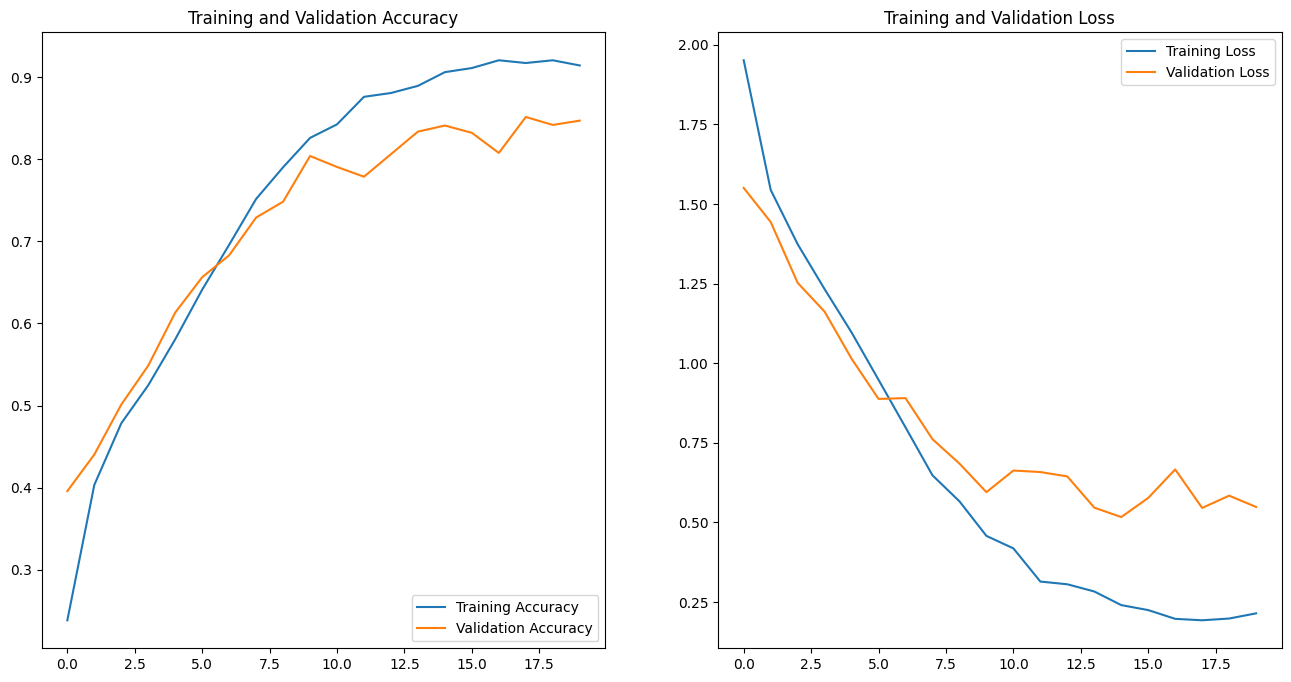

In [ ]:
model_metrics_visualization(history, epochs)

## Finding:

The accuracy of the model has improved a lot and so is the loss. Therefore, we can conclude that by class rebalancing, we are able to improve our model.